In [2]:
import pandas as pd
import numpy as np

In [19]:
russell_df = pd.read_csv("russell2000pvdata.csv", on_bad_lines='skip')
vars = ['open', 'high', 'low', 'close', 'volume']
universesize = 2000
reversiontimehorizon = 10
maxindividualweight = 0.01
rawdata = {}
russell_df

,tickerid,ticker,date,open,high,low,close,volume
0,1,FLWS,20101227,2.780000,3.040000,2.760000,2.900000,411500.0
1,1,FLWS,20101228,2.910000,2.970000,2.790000,2.850000,210900.0
2,1,FLWS,20101229,2.840000,2.880000,2.750000,2.810000,114500.0
3,1,FLWS,20101230,2.770000,2.840000,2.710000,2.720000,135300.0
4,1,FLWS,20101231,2.700000,2.750000,2.620000,2.690000,158100.0
...,...,...,...,...,...,...,...,...
3886875,1968,PHDG,20201217,32.709999,32.779999,32.689999,32.730000,25600.0
3886876,1968,PHDG,20201218,32.700001,32.779999,32.639999,32.770000,21700.0
3886877,1968,PHDG,20201221,32.689999,32.830002,32.560001,32.810001,26100.0
3886878,1968,PHDG,20201222,32.910000,32.910000,32.680000,32.680000,18000.0


In [20]:
for tvar in vars:
    rawdata[tvar] = russell_df.loc[:, ['tickerid', 'ticker', 'date', tvar]]
    rawdata[tvar] = rawdata[tvar].pivot(index = 'date', columns = 'ticker', values = tvar)
    rawdata[tvar] = rawdata[tvar].iloc[:, :universesize]

In [37]:
return_df = (rawdata['close'] / rawdata['close'].shift(1)) - 1
signal_df = -return_df.rolling(reversiontimehorizon, min_periods = 3).mean()
signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
signal_df = signal_df.shift(1) 
for i in range(3):
    signal_df[signal_df > maxindividualweight] = maxindividualweight
    signal_df[signal_df < -maxindividualweight] = -maxindividualweight
    signal_df = signal_df.subtract(signal_df.mean(axis=1), axis='index')
    signal_df = signal_df.divide(signal_df.abs().sum(axis=1), axis='index')
pnl_df = signal_df * return_df.shift(-1)
pnl = pnl_df.sum(axis=1)

In [40]:
def pnlPerformance(pnl, label):
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    print("")
    print ("PERFORMANCE STATISTICS FOR "+label);
    print("Daily annualized sharpe: "+str(sharpe))
    print ("Average annual returns: "+str(pnl.mean()*252*100)+"%")
    print ("Total returns: "+str(pnl.sum()*100)+"%");
    ######### exam
    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    print ("Max drawdown: "+str(maxdrawdown*100)+"%");
    plt.plot(cumpnl.values, label = label);
    plt.legend();
    plt.title("Cumulative PNL chart")
    plt.show(block=False);
    #HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    stressedmarkets["Covid19"] = (20200301, 20200317);          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = (20181215, 20181231);            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = (20150701, 20150901);         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = (20141001, 20141031);            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = (20130820, 20130825);          #Flash freeze on 22 Aug 2013

    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        print("Stressed period return during "+tkey+":  "+str(pnl[mask].sum()*100)+"%")
    print("===========================")
    print("")


PERFORMANCE STATISTICS FOR MARKET NEUTRAL
Daily annualized sharpe: 1.5265542699663794
Average annual returns: 14.496722334170729%
Total returns: 144.79464331391952%
Max drawdown: -20.917597058487193%


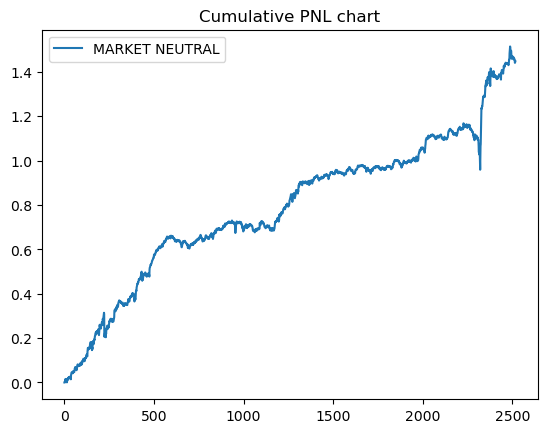

Stressed period return during Covid19:  -13.609529615513896%
Stressed period return during Dec18:  3.5765779786037366%
Stressed period return during Fall2015:  2.147954666945533%
Stressed period return during Oct14:  0.4763952234596674%
Stressed period return during Aug2013:  -0.11368183480925491%



In [41]:
pnlPerformance(pnl, "MARKET NEUTRAL")

In [42]:
marketneutralportfolio = signal_df.copy(deep=True)

In [43]:
def portfolioDiagnostics(signal_df, label):
    #NET SECTOR EXPOSURES
    import matplotlib.pyplot as plt
    plt.figure();
    #sector_df = pd.read_csv("sector.csv", error_bad_lines = False)
    sector_df = pd.read_csv("sector.csv", on_bad_lines='skip')
    d = sector_df.set_index('ticker').to_dict()
    signal_df2 = signal_df.copy(deep=True)
    signal_df2.columns = signal_df2.columns.to_series().map(d['sector'])
    uniquesector = list(set(signal_df2.columns))
    for tsector in uniquesector:
        if (str(tsector)=='nan'):
            continue;
        tmean = signal_df2.loc[:, tsector].sum(axis=1)
        tmean[~np.isfinite(tmean)] = 0
        plt.plot(tmean.values, label=tsector)
        plt.legend();
        plt.title(label+" NET EXPOSURE")
        plt.show(block=False)
    return

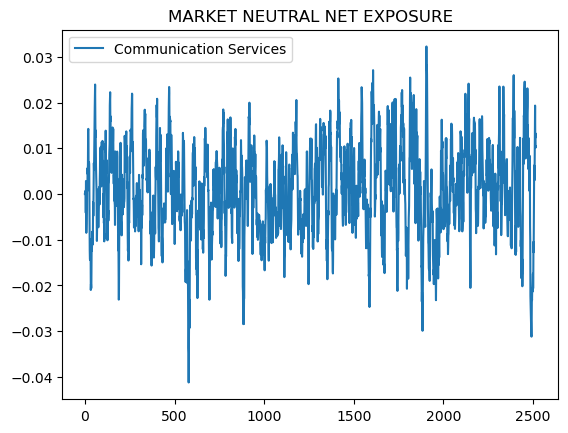

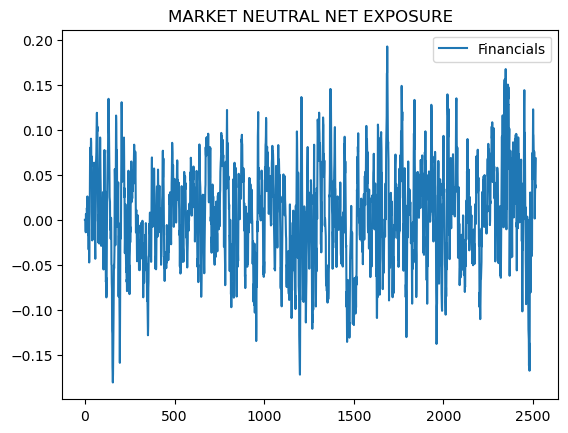

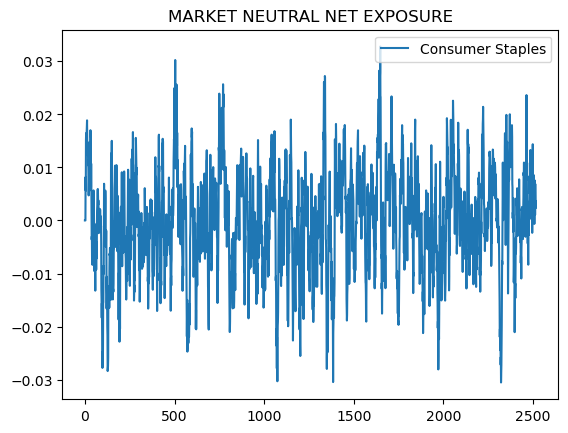

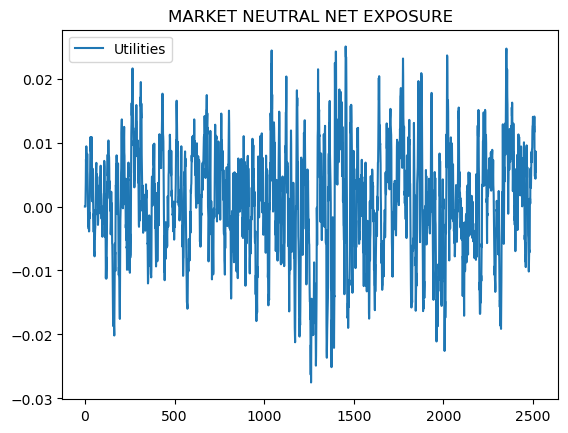

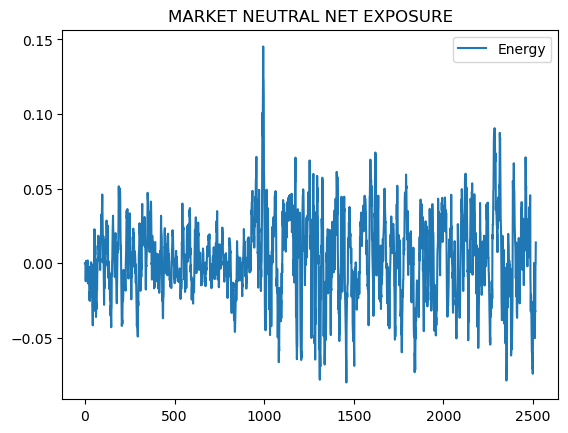

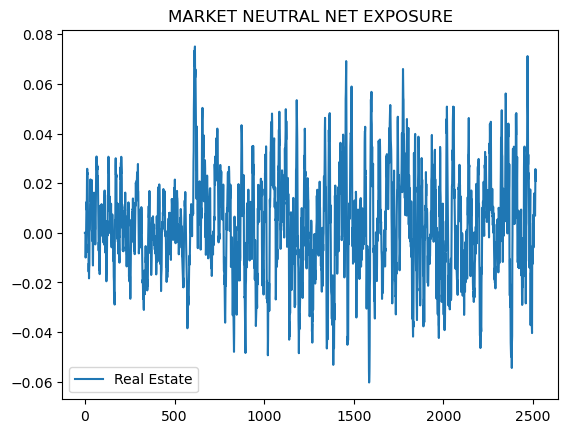

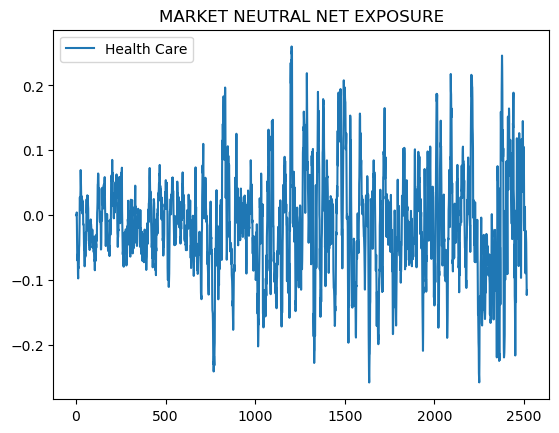

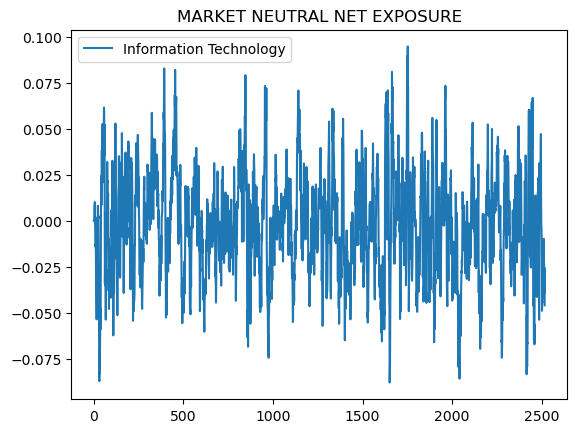

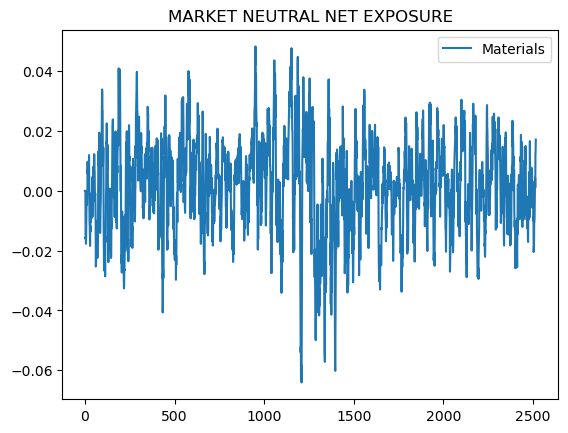

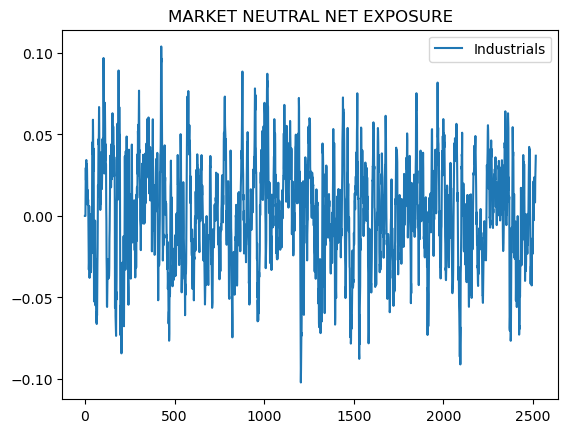

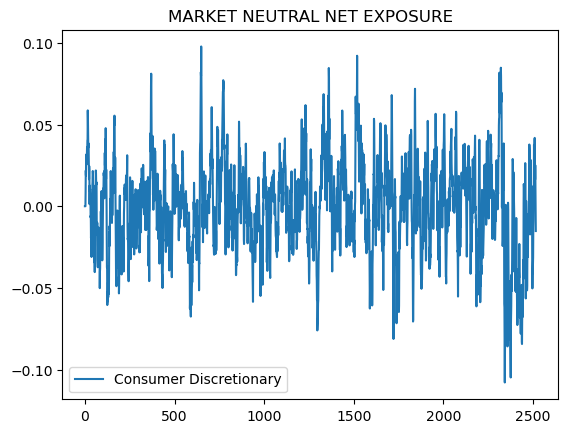

In [44]:
portfolioDiagnostics(marketneutralportfolio, "MARKET NEUTRAL");